# Essayons de trouver quelles données GPS de match peuvent expliquer ou du moins avoir un lien avec les variations de score du RSI

Pour cela nous allons réaliser une régression linéaire multiple (expliquer une donnée quantitative par des données quantitatives).<br>
Le test de saut RSI est réalisé le premier jour de la semaine suivant le match, nous allons procédér à une première manipulation des données (plusieurs bases de données à croiser) afin de garder les données les plus consistantes (ne pas dépasser 3 jours entre le match et le saut)

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from IPython.display import Image

In [2]:
data_gps = pd.read_excel(r'C:\Users\raflg\Downloads\Databases\GPS_data.xls')
data_rsi = pd.read_excel('C:/Users/raflg/Downloads/S&C/Excel/Hurricanes/Hurricanes NMF.working.xlsx', sheet_name='Data2')

In [3]:
#Données GPS de matchs

gps_games = data_gps[data_gps['Type']=='Game'].copy().reset_index(drop=True)

In [4]:
#Modifions les valeurs textes de quelques colonnes pour les correspondances entre les bases de données
data_rsi['Week'] = data_rsi['Week'].str.split(' -').str[0]
data_rsi['Name'] = data_rsi['Name'].str.split(' ').str[1] + ', ' + data_rsi['Name'].str.split(' ').str[0]

In [5]:
#Trouvons les joueurs en commun dans les deux bases de données

rsi_players = data_rsi.Name.unique()

#Sélectionnons seulement les joueurs en commun
gps_games = gps_games[gps_games['Athlete'].isin(rsi_players)].reset_index(drop=True)

Première méthode pour trouver les valeurs correspondantes : décaler n-1 les valeurs textes de la semaine dans la base de données RSI

In [6]:
data_rsi['Week_N-1'] =  pd.to_numeric(data_rsi.Week.str.split(' ').str[1]) - 1
data_rsi['Week_N-1'] =  'Week' + ' ' + data_rsi['Week_N-1'].astype(str)

Cette méthode nous permet de faire correspondre les valeurs RSI avec les valeurs GPS de la semaine précédant le saut

In [7]:
gps_rsi = gps_games.merge(data_rsi, how='left', left_on=['Athlete', 'Week'], right_on=['Name', 'Week_N-1'],
                          suffixes=('_gps', '_rsi'))

In [8]:
gps_rsi.dropna(subset=['RSI'], inplace=True)
gps_rsi.reset_index(drop=True, inplace=True)

La deuxième méthode, peut être plus précise, va nous permettre de s'assurer que nous gardons uniquement les données RSI et GPS si 3 jours maximum séparent le match et le saut (les matchs pouvaient être le vendredi ou le samedi)

In [9]:
dfs_ = []
for n in data_rsi.Name.unique():
    rsi_sub = data_rsi[data_rsi['Name']==n].copy()
    gps_sub = gps_games[gps_games['Athlete']==n].copy()
    
    sub_ = []
    for d in rsi_sub.Date:
        try:
            date_theoretical = d - pd.DateOffset(days=3)
    
            gps_sub_sub = gps_sub[(gps_sub['Date'] >= date_theoretical) & (gps_sub['Date'] < d)].copy()
            gps_date = max(gps_sub_sub.Date)
        
            rsi_result = rsi_sub.loc[rsi_sub['Date']==d, 'RSI'].values[0]
        
            gps_sub_sub.loc[gps_sub_sub['Date']==gps_date, 'RSI'] = rsi_result
            gps_sub_sub.loc[gps_sub_sub['Date']==gps_date, 'Dates_diff'] = d - gps_date
            gps_sub_sub = gps_sub_sub.dropna(subset=['RSI'])
        
            sub_.append(gps_sub_sub)
            
        except:
            pass
    
    if sub_:
        dfs_.append(pd.concat(sub_))

In [10]:
gps_rsi_bis = pd.concat(dfs_).reset_index(drop=True)

### Nous pouvons à présent nous lancer dans la régression linéaire multiple

In [11]:
import statsmodels.formula.api as smf

In [12]:
ols_columns = ['Distance Total (m)', 'High Int Speed (m)', 'Sprints (m)', 'Hi Int Acceleration (nb)', 
               'Hi Int Deceleration (nb)', '>85% Distance (m)', 'RSI']

In [13]:
reg_df = gps_rsi[ols_columns].copy()
reg_df = reg_df.rename(columns={'Distance Total (m)':'Dist_Total', 'High Int Speed (m)':'HI_Speed',
                                'Sprints (m)':'Sprints', 'Hi Int Acceleration (nb)':'HI_Acc',
                                'Hi Int Deceleration (nb)':'HI_Dec', '>85% Distance (m)':'VHI_Dist'})

Les variables sont donc :
- Dist_Total : distance totale parcourue, en mètre
- Hi_Speed : distance totale parcourue à haute intensité, en mètre
- Sprints : distance totale parcourue en sprint, en mètre
- HI_Acc : nombre total d'accélérations à haute intensité 
- HI_Dec : nombre total de décelérations à haute intensité
- VHI_Dist : distance totale parcourue >85% de la vitesse maximale, en mètre

Nous visualisons les relations entre chaque variable entre elle

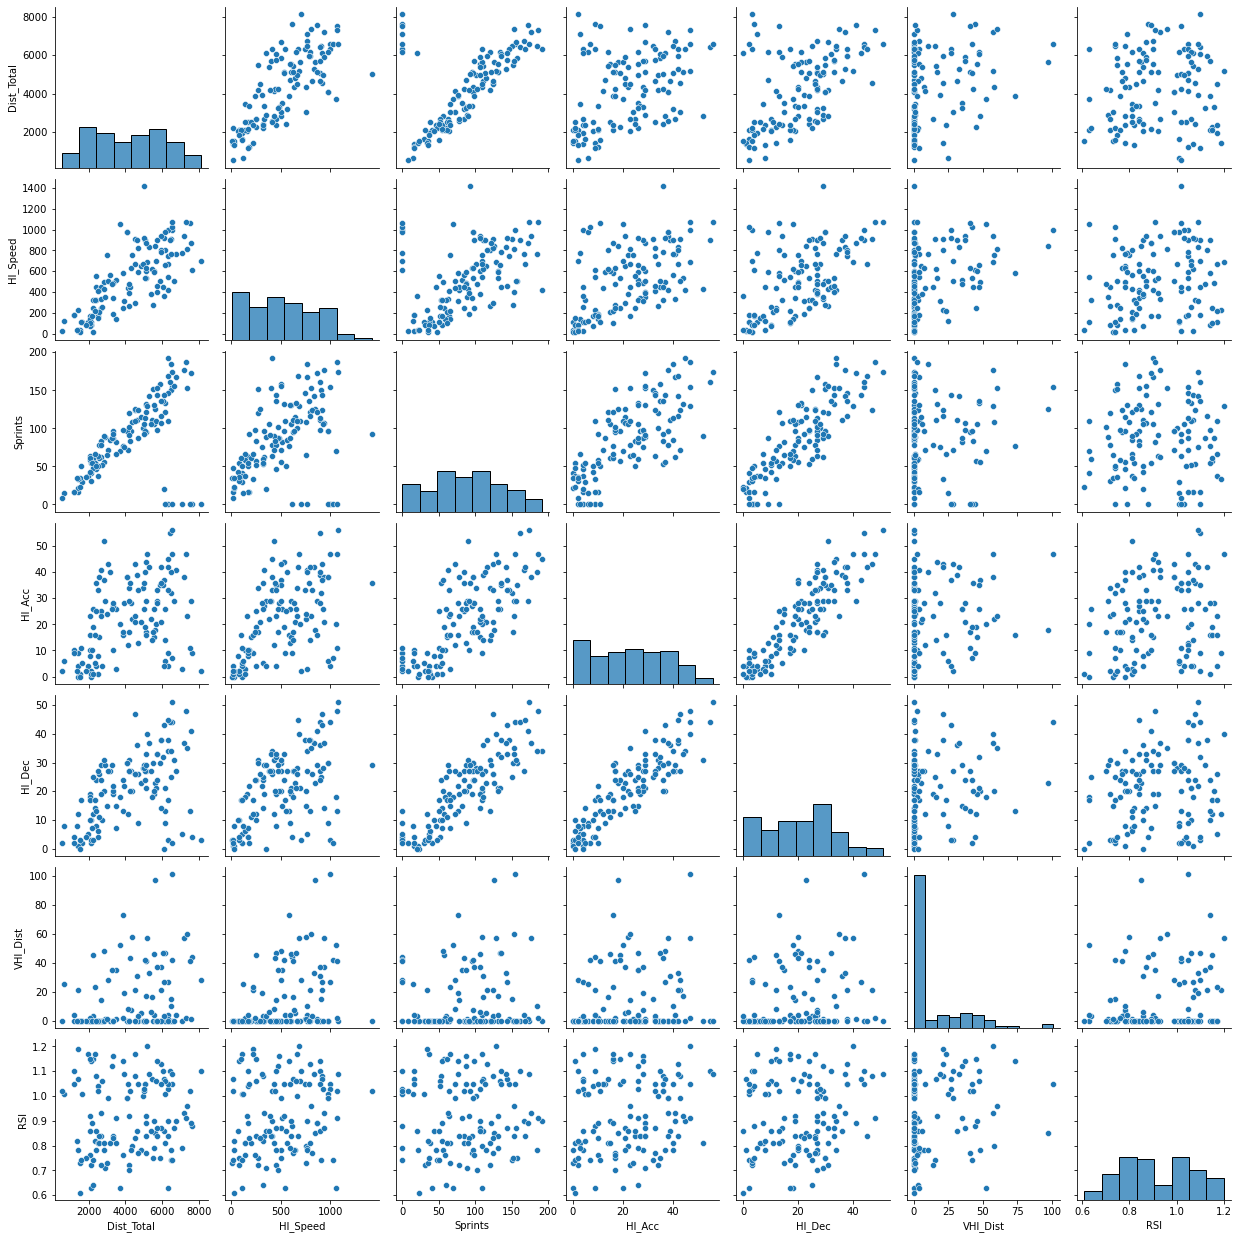

In [14]:
sns.pairplot(reg_df)

Nous avons quelques règles à respecter donc bien respectées ici :<br>
- Aucune multicolinéarité parfaite<br>
- Pas de corrélation entre les variables indépendantes et la variables externe (RSI)<br>

Nous constatons des corrélations fortes entre certaines variables : Dist_Total et Sprints ; Hi_Acc et Hi_Dec.
A partir de là, il y a le choix de ne retenir qu'une seule des deux variables pour représenter le duo en quelques sortes. Cependant pour le premier duo Dist_Total et Sprints, nous perdrons de l'information de par la nature de ces variables (biomécanique, physiologique). De plus, nous ne disposons pas d'un grand nombre de variables donc nous ferons le choix de les garder.
Pour aller plus loin, avec un grand nombre de variables, nous pouvons réaliser une VIF (Variance Infletion Factor ou facteur d'inflation de variance) pour détecter la gravité de la multicolinéarité et de supprimer des variables avant de lancer le modèle de régression

In [15]:
reg = smf.ols('RSI ~ Dist_Total+HI_Speed+Sprints+HI_Acc+HI_Dec+VHI_Dist', data=reg_df)
res = reg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RSI   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     2.464
Date:                Mon, 04 Jul 2022   Prob (F-statistic):             0.0280
Time:                        14:39:39   Log-Likelihood:                 66.159
No. Observations:                 123   AIC:                            -118.3
Df Residuals:                     116   BIC:                            -98.63
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8825      0.034     26.033      0.000       0.815       0.950
Dist_Total  3.767e-06   1.28e-05      0.294      0.770   -2.16e-05    2.92e-05
HI_Speed   -2.437e-06   7.53e-05     -0.032      0.974      -0.000       0.000
Sprints       -0.0013      0.001     -2.180      0.031      -0.002      -0.000
HI_Acc         0.0022      0.002      1.079      0.283      -0.002       0.006
HI_Dec         0.0032      0.003      1.060      0.292      -0.003       0.009
VHI_Dist       0.0013      0.001      1.936      0.055   -2.98e-05       0.003
==============================================================================
Omnibus:                        4.561   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                2.489
Skew:                           0.055   Prob(JB):                        0.288
Kurtosis:                       2.312   Cond. No.                     1.20e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Nous pouvons rejetter H0 (H0 : il n'y a pas de variable explicative) : il y a au moins une variable explicative (p<0.05).<br>
Et nous observons qu'uniquement Sprints (distance totale parcourue à allure de sprint) est la variable qui apporte de l'information. Ce qui signifie que  pour chaque mètre supplémentaire à vitesse de sprint, nous pouvons nous attendre à ce que le RSI diminue de 0.0013

Voyons à présent à l'aide d'un package sur R une méthode pour sélectionner uniquement les variables intéressantes

Pour une simplicité de lecture et éviter le changement de page, les résultats sous R se trouvent ci-dessous en capture d'écran (de plus, il n'y a que 4 lignes de code)

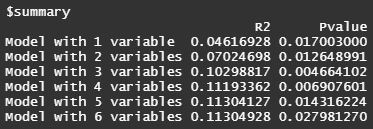

In [20]:
Image(filename='C:/Users/raflg/Downloads/Databases/Régression linéaire multiple/Summary.jpg')

Le meilleur modèle de prévision contient donc 3 variables (meilleur p-value)

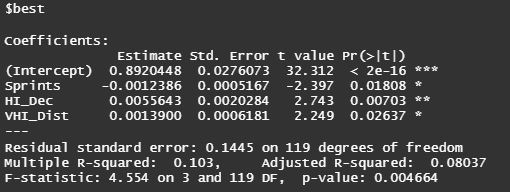

In [21]:
Image(filename='C:/Users/raflg/Downloads/Databases/Régression linéaire multiple/Best.jpg')

Le meilleur modèle à 3 variables et donc celui-ci et on obtient la formule suivante :

RSI = 0.89 - 0.001 x Sprints + 0.006 x Hi_Dec - 0.001 x VHI_Dist

Qui se traduit par : pour chaque mètre de sprint parcouru le RSI diminue de 0.001, pour chaque décelération le RSI augmente de 0.006 et pour chaque mètres >85% de vitesse max parcouru le RSI diminue de 0.001

Nous pouvons à nouveau réaliser la régression linéaire multiple avec les 3 variables sélectionnées et obtenir les intervalles de confiance des coefficients de ces variables dans le modèle:

Sprints : -0.002--0<br>
HI_Dec : 0.002--0.1<br>
VHI_Dist : 0--0.003

In [22]:
reg = smf.ols('RSI ~ Sprints+HI_Dec+VHI_Dist', data=reg_df)
res = reg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RSI   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     4.554
Date:                Mon, 04 Jul 2022   Prob (F-statistic):            0.00466
Time:                        15:15:26   Log-Likelihood:                 65.466
No. Observations:                 123   AIC:                            -122.9
Df Residuals:                     119   BIC:                            -111.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8920      0.028     32.312      0.000       0.837       0.947
Sprints       -0.0012      0.001     -2.397      0.018      -0.002      -0.000
HI_Dec         0.0056      0.002      2.743      0.007       0.002       0.010
VHI_Dist       0.0014      0.001      2.249      0.026       0.000       0.003
==============================================================================
Omnibus:                        6.361   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.042   Jarque-Bera (JB):                2.969
Skew:                           0.011   Prob(JB):                        0.227
Kurtosis:                       2.239   Cond. No.                         220.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion

Les coefficients et les intervalles sont des nombres très petits de par les valeurs petites du RSI et les grandes valeurs des différentes variables GPS. Egalement le RSI a une variabilité assez faible.
A noter que le modèle a un R² de 0.103 donc le modèle explique 10.3% de la variabilité du RSI.

De plus, le modèle nous confirme des choses que nous savons déjà par expérience : les efforts intenses (à dominante neurale) vont avoir plus d'impact sur le score RSI (obtenu d'un effort neural également). Il est tout de même intéressant de noter que les décelérations auraient un effet positif sur le score RSI.

Enfin, pour conclure, la principale limite de la méthode et des conclusions est que nous ne prenons pas en compte l'environnement du sportif entre le match et le saut : les deux étant séparés entre 2 et 3 jours, la qualité de vie, récupération etc. du sportif vont beaucoup jouer sur sa qualité de saut réalisé en début de semaine

(Et ici la base de données manque de consistance : beaucoup de joueurs avec une seule saisie, seulement 3 joueurs avec 8 saisies...)

### Perspectives

Pour être plus précis et espérer avoir un modèle plus performant, nous pourrions nous procurer davantage de données des matchs comme : la durée de jeu, des données sur les contacts (nombre et intensité), découper en zone d'intensité (km/h, m.s-²) les efforts intenses (sprints, accélérations, décelérations) ou encore une information sur le match (domicile ou extérieur, moyen de transport).

Nous pourrions analyser chaque joueur avec suffisamment de données individuelles ou encore par groupes (avants et arrières).

Enfin, nous pourrions nous intéresser aux composantes du RSI dans le modèle de régressions multiple. Car ce score est un ratio ou un produit (selon le calcul, https://www.scienceforsport.com/reactive-strength-index/). Il serait donc plus intéressant de savoir quelle composante peut être le mieux expliquée par les données de match